## Model Explainability

The growing availability of big data has increased the benefits of using complex models, so data scientists often have to choose between accuracy and interpretability of a model’s output. Adding explainability methods to models that are not easily understood are able to ensure algorithmic fairness, identify potential bias in the training data, and support an overall better understanding of the process being modeled. At the highest level, these methods are able to give insight into why your model generates specific outputs. We'll explore just one of the many explainability methods in this notebook. 

Let's start by loading in the dataset.

In [1]:
import pandas as pd
import os.path

feats = pd.read_parquet(os.path.join("data", "features.parquet"))

We have to edit some of the fields in our dataset in order to comply with the explainability method. Because models don't understand written language in the ways humans do, we will translate the `label` variable into [dummy variables](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) using a [One Hot encoder](https://en.wikipedia.org/wiki/One-hot). The output will be two columns, `spam` and `legitimate` , where the labels are either 0 or 1 to identify each type of email. Having two columns is redundant, as a label of 0 for `legitimate` would be the equivalent of a label of 1 for `spam` column, so we will drop one column (`spam`, specifically but arbitrarily chosen) in order to reduce redundancy. We'll also create a copy of the data not containing the "correct answers," so we are not training the model with the answers included.

In [2]:
from sklearn import model_selection

feats2 = pd.get_dummies(feats['label'])
data = pd.concat([feats2, feats], axis=1)
data.drop(['spam', 'label'], inplace = True, axis=1)

data2 = data.drop("legitimate", axis = 1)

We split the data into training and testing sets, as in other notebooks, using the `random_state` parameter to ensure that the data is split in the same way as it was when we fit the model.

In [3]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data2, 
                                                                    data['legitimate'],  
                                                                    test_size=0.2, 
                                                                    random_state=430)

Pipeline protocols broken in python 3.7.3 (which is what is running here), so retraining model from scratch using same hyperparamters.

In [4]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

train, test = model_selection.train_test_split(feats, random_state=43)

model = LogisticRegression(solver = 'lbfgs', max_iter = 4000)

model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Now let's generate predictions and test out our model.

In [5]:
predictions = model.predict(x_test)

In [6]:
# idx of 1 will create incorrect prediction, idx of 0 will create correct prediction
idx = 1

print("The predicted value is ", predictions[idx] , " and the actual value is ", y_test.iloc[idx])

The predicted value is  1  and the actual value is  0


Oh no! Our model seems to have misclassified this instance. However, we don't have much intituion as to why this happened. Are there too many stop words? Lots of punctatuation? Explainability methods exist to offer ways to explore the decision making process of black-box models such as this one. Let's see if we can figure out why this prediction was made.

Note: not using alibi.explainers since its dependencies conflict with alibi-detect (which is in data drift notebook). Instead, using ```shap``` library, which is what alibi is based off of for this code.__

One type of explainability method is a version of [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html), or SHapley Additive exPlanations, where a local prediction is explained by displaying each feature's  contribution to the prediction. The output of a SHAP method is a linear model created for a particular instance.

In [7]:
#import alibi
#from alibi.explainers import KernelShap
import shap

explainer = shap.KernelExplainer(model.predict_proba, x_train)
shap_values = explainer.shap_values(x_test.iloc[0,:])

print(x_train)

Using 32000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


       index  no_punct  number_words   mean_wl  max_wl  min_wl  pc_10_wl  \
37540  17540         9            31  4.000000      10       1       1.0   
13178  13178        24           116  4.491379      12       1       2.0   
12293  12293        11            79  4.481013      11       1       2.0   
27376   7376        12            70  4.442857      12       1       2.0   
6814    6814        20           122  4.418033      13       1       2.0   
...      ...       ...           ...       ...     ...     ...       ...   
27981   7981        12            80  4.050000      11       1       2.0   
6164    6164        13            90  4.300000      13       1       2.0   
1127    1127        13            83  4.120482      17       1       2.0   
21827   1827        16           119  4.193277      12       1       2.0   
22741   2741        11            73  4.246575      10       1       2.0   

       pc_90_wl  upper  stop_words  
37540       7.0      5          14  
13178       8

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


This output seems like it could be helpful, but doesn't give us a very intuitive explanation of what is happening. We'll use the ```force_plot``` visualization to better understand the local linear model generated by SHAP.

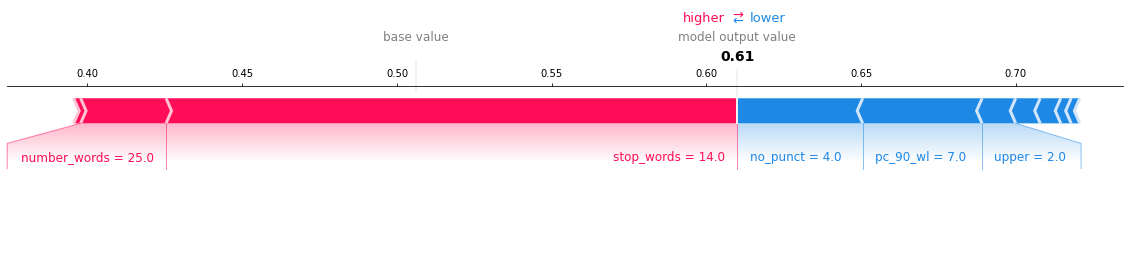

In [12]:
shap.force_plot(explainer.expected_value[idx], 
                shap_values[idx], 
                x_test.iloc[idx,:],
               matplotlib=True)

We can see from the plot that the `stop_words` and `number_words` variables had the biggest influence on the model's decision to classify this instance as legitimate when it is actually spam. _Explainers are not built to fix problems in models, but rather expose them._ Knowing that our model may weight these variables more heavily than necessary can help us improve the model, if we chose to make changes. We could also look at other explainability methods such as [counterfactuals](https://christophm.github.io/interpretable-ml-book/counterfactual.html) to find out what changes to the input would create the correct classification.